# Use latent states to decode neural identity

1. Hold out the identity of a handful of neurons during training
2. Fit the model to the remaining neurons
3. Regress heldout neural activity onto the latent states to get weights $c_{n^*}$
4. Find the observed neurons whose $c_n$ emission vectors best align with $c_{n^*}$
5. Use this as a measure of similarity to inform a matching algorithm.  
6. Use Hungarian algorithm to find best matching between heldout neurons and observed identities. 
7. Measure classification accuracy


In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(1234)

In [2]:
# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimation

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

In [3]:
# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load basic pyslds models
from pyslds.models import HMMSLDS, WeakLimitStickyHDPHMMSLDS

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.models
importlib.reload(zimmer.models)
from zimmer.models import HierarchicalWeakLimitStickyHDPHMMSLDS, HierarchicalRecurrentSLDS, HierarchicalRecurrentOnlySLDS
from zimmer.emissions import HierarchicalDiagonalRegression

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie

from zimmer.util import states_to_changepoints

In [4]:
# IO
run_num = 1
results_dir = os.path.join("results", "neuron_identification", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Specify the signal to model
signal = "dff_deriv"

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 3   # latent linear dynamics' dimension
D_in = 1       # number of input dimensions
D_obs = 60

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 100.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0  # Gamma prior for emission variance

# Number of worms to fit
N_worms = 5

In [5]:
def cached(results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                assert os.path.exists(results_dir)
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper
    return _cache

# Load the data

In [7]:
# Load the data
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [getattr(wd, signal) for wd in worm_datas]

if signal == "dff_deriv":
    Ys = [Y * 10 for Y in Ys]

# Get the "true" discrete states as labeled by Zimmer
z_trues = [wd.zimmer_states for wd in worm_datas]
perm_z_trues, newlabels = relabel_by_usage(z_trues, return_mapping=True)
z_trues = perm_z_trues

# Get the key
z_key = load_key()
perm_z_key = [z_key[i] for i in np.argsort(newlabels)]
z_key = perm_z_key

# Get the names of the neurons
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = all_neuron_names.size
print("{} neurons across all {} worms".format(N_neurons, N_worms))

# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
print("{} shared neurons".format(len(shared_neurons)))
Ys_shared = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    Ys_shared.append(Y[:, shared_indices])

# Construct a big dataset with all neurons for each worm
datasets = []
data_masks = []
for wd in worm_datas:
    this_dataset = np.zeros((wd.T, N_neurons))
    this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
    indices = wd.find_neuron_indices(all_neuron_names)
    for n, index in enumerate(indices):
        if index is not None:
            this_dataset[:,n] = getattr(wd, signal)[:, index]
            this_mask[:,n] = True

    datasets.append(this_dataset)
    data_masks.append(this_mask)

477 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


In [8]:
print([m[0,:D_obs].sum() for m in data_masks])
N_heldout = 5
heldout_neurons = []
for m in data_masks:
    observed = np.where(m[0,:D_obs])[0]
    heldout_neurons.append(np.random.choice(observed, size=5, replace=False))
    print("holding out: ", heldout_neurons[-1])
    m[:,heldout_neurons[-1]] = False
print([m[0,:D_obs].sum() for m in data_masks])

# Make sure that we haven't thrown out the only instance of a neuron
assert(np.all(np.vstack(data_masks).sum(0) > 0))

[23, 40, 29, 42, 47]
holding out:  [12 28  2  6  1]
holding out:  [23 34 35  9  7]
holding out:  [ 0 50  1 42 59]
holding out:  [24  2  5 30  8]
holding out:  [22 50 51 35  6]
[18, 35, 24, 37, 42]


# Initialize latent states with PCA

90% variance explained:  9
3 PCs capture:  0.697690087237
90% variance explained:  9
3 PCs capture:  0.696392879184
90% variance explained:  15
3 PCs capture:  0.591258088141
90% variance explained:  15
3 PCs capture:  0.654669233579
90% variance explained:  13
3 PCs capture:  0.532089042023


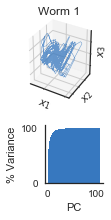

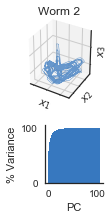

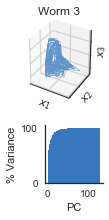

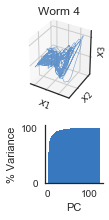

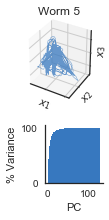

In [10]:
def plot_pca_trajectories(worm, Y):
    # Try to reproduce their plot of PC's over time
    n_comps = Y.shape[1]
    pca = PCA(n_components=n_comps, whiten=True)
    pca.fit(Y)

    x_pca = pca.transform(Y)

    fig = plt.figure(figsize=(1.5,3.))
    ax = create_axis_at_location(fig, 0.2, 1.5, 1.1, 1.25, projection="3d")
    ax.plot(x_pca[:,0], x_pca[:,1], x_pca[:,2], lw=0.5, alpha=0.75, ls='-', color=colors[0])
    ax.set_xlabel("$x_1$", labelpad=-12)
    ax.set_ylabel("$x_2$", labelpad=-12)
    ax.set_zlabel("$x_3$", labelpad=-12)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title("Worm {}".format(worm+1))

    # Plot percent variance explained
    ax = create_axis_at_location(fig, .55, 0.4, .8, .8, box=False)
    ax.patch.set_alpha(0.0)
    ax.bar(np.arange(n_comps),  100 * np.cumsum(pca.explained_variance_ratio_), width=1, color=colors[0])
#     ax.plot(np.arange(n_comps), 90 * np.ones(n_comps), ':r')
    ax.set_xlabel("PC")
    ax.set_ylabel("% Variance")

    print("90% variance explained: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .90)[0][0])
    print("3 PCs capture: ", np.sum(pca.explained_variance_ratio_[:3]))
#     plt.savefig(os.path.join(results_dir, "pca_trajectory_worm{}.pdf".format(worm)))
    
#     plt.figure()
#     plt.hist2d(x_pca[:,0], x_pca[:,1], np.linspace(-3, 3, 25))

# Plot PCA trajectories for first worm
for i in range(N_worms):
    plot_pca_trajectories(i, Ys[i])

In [11]:
@cached("pca")
def fit_pca(Ys_shared):
    # Try to reproduce their plot of PC's over time
    pca = PCA(n_components=D_latent, whiten=True)
    pca.fit(np.vstack(Ys_shared))

    x_inits = [pca.transform(Y) for Y in Ys_shared]
    C_init = pca.components_.T
    return x_inits, C_init


# Fit PCA and plot the latent states
x_inits, C_init = fit_pca(Ys_shared)


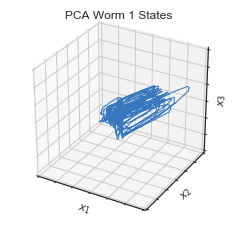

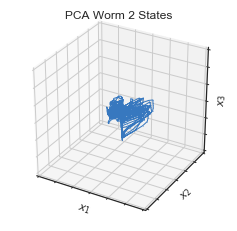

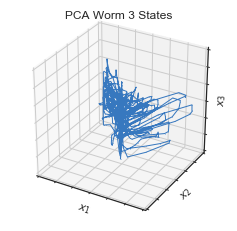

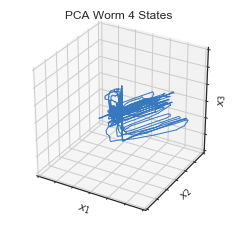

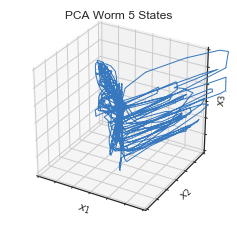

In [12]:
for worm in range(N_worms):
    plot_3d_continuous_states(x_inits[worm], np.zeros(Ts[worm], dtype=np.int32), colors,
                              figsize=(4, 4),
                              title="PCA Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename=None,
                              lw=1,
                              lim=6)

# Fit some models

In [17]:
def make_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        DiagonalRegression(
            D_obs, D_latent + D_in,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

# Fit standard LDS models

In [18]:
def _fit_lds(x_inits, ys, masks, N_gibbs=500):
    print("Fitting standard LDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    # LDS is a switching LDS with one state
    lds = HMMSLDS(
        init_dynamics_distns=init_dynamics_distns[:1],
        dynamics_distns=dynamics_distns[:1],
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')
    
    # Add the data
    for y, mask, xi in zip(ys, masks, x_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        lds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            lds.states_list[-1].gaussian_states = xi[:, :D_latent]

    # Resample parameters once to be consistent with x_init
    lds.resample_parameters()
    
    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        return ll

    def update_gibbs(model):
        model.resample_model()
        return evaluate(model)
    
    lls  = [update_gibbs(lds) for itr in progprint_xrange(N_gibbs)]
    lls = np.array(lls)

    # Compute the smoothed continuous state trajectories
    for states in lds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in lds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in lds.states_list]

    return lds, lls, x_finals, sigma_x_finals

Fitting standard LDS
.........................  [  25/500,    0.27sec avg, ETA 02:09 ]
.........................  [  50/500,    0.27sec avg, ETA 02:02 ]
.........................  [  75/500,    0.27sec avg, ETA 01:53 ]
.........................  [ 100/500,    0.26sec avg, ETA 01:45 ]
.........................  [ 125/500,    0.26sec avg, ETA 01:38 ]
.........................  [ 150/500,    0.26sec avg, ETA 01:30 ]
.........................  [ 175/500,    0.25sec avg, ETA 01:22 ]
.........................  [ 200/500,    0.25sec avg, ETA 01:14 ]
.........................  [ 225/500,    0.24sec avg, ETA 01:07 ]
.........................  [ 250/500,    0.24sec avg, ETA 01:01 ]
.........................  [ 275/500,    0.24sec avg, ETA 54.58 ]
.........................  [ 300/500,    0.24sec avg, ETA 48.45 ]
.........................  [ 325/500,    0.24sec avg, ETA 42.15 ]
.........................  [ 350/500,    0.24sec avg, ETA 35.92 ]
.........................  [ 375/500,    0.24sec avg, E

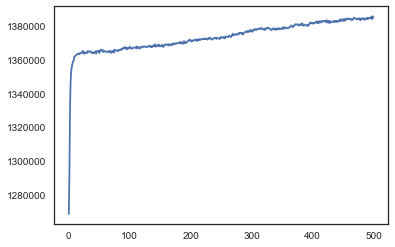

In [19]:
# Fit an LDS to all the data
fit_joint_lds = cached("lds_joint")(_fit_lds)
# fit_joint_lds = (_fit_lds)
lds, lds_lls, lds_x_finals, lds_sigma_x_finals = \
        fit_joint_lds(x_inits=None, 
                      ys=[y[:,:D_obs] for y in datasets], 
                      masks=[m[:,:D_obs] for m in data_masks], 
                      N_gibbs=500)
    
plt.plot(lds_lls)

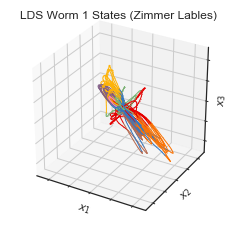

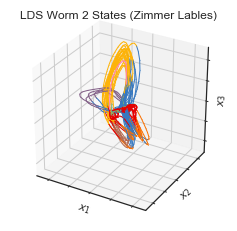

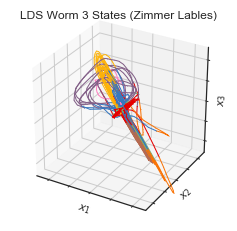

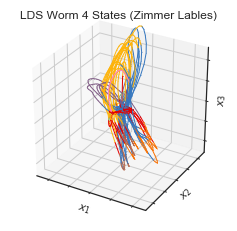

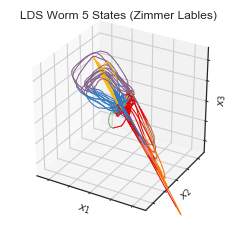

In [20]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], z_trues[worm], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_zimmer_{}.pdf".format(worm + 1),
                              lim=25,
                              lw=1)

# Fit standard SLDS models

In [21]:
def _fit_slds(z_inits, ys, masks, N_samples=500, init_lds=None):
    print("Fitting standard SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    z_inits = [None] * len(ys) if z_inits is None else z_inits
    
    slds = WeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for y, mask, zi in zip(ys, masks, z_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        slds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize discrete latent states
        if zi is not None:
            slds.states_list[-1].stateseq = zi
        else:
            runlen = 10
            z0 = np.random.choice(Kmax, size=(T // 10))
            z0 = np.repeat(z0, runlen)
            z0 = z0[:T] if len(z0) > T else z0
            z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
            z0 = z0.astype(np.int32)
            assert len(z0) == T
            slds.states_list[-1].stateseq = z0
            
    if init_lds is not None:
        assert len(init_lds.states_list) == len(ys)
        slds._emission_distn = copy.deepcopy(init_lds._emission_distn)
            
        for s1,s2 in zip(init_lds.states_list, slds.states_list):
            s2.gaussian_states = s1.gaussian_states.copy()

        for k in range(Kmax):
            slds.init_dynamics_distns[k] = copy.deepcopy(init_lds.init_dynamics_distns[0])
            slds.dynamics_distns[k] = copy.deepcopy(init_lds.dynamics_distns[0])
            slds.emission_distns[k] = slds._emission_distn
            
    # Resample parameters once to be consistent with x_init
    else:
        slds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model):
        model.resample_model()
        return evaluate(model)

    smpls = [update(slds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(len(ys)):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
    perm = np.argsort(iperm)
    z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in slds.states_list]
    
    # Permute the dynamics and transition distribution
    perm_init_dynamics_distns = [slds.init_dynamics_distns[i] for i in perm]
    perm_dynamics_distns = [slds.dynamics_distns[i] for i in perm]
    perm_trans_matrix = slds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
    # Update the model accordingly
    slds.init_dynamics_distns = perm_init_dynamics_distns
    slds.dynamics_distns = perm_dynamics_distns
    slds.trans_distn.trans_matrix = perm_trans_matrix
    for s, zp in zip(slds.states_list, z_finals):
        s.stateseq = zp.copy()

    # Compute the smoothed continuous state trajectories
    for states in slds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in slds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in slds.states_list]

    return slds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

In [22]:
fit_joint_slds = cached("slds_joint")(_fit_slds)
# fit_joint_slds = _fit_slds
slds, slds_lls, slds_z_smpls, slds_dynamics_distns, \
    slds_z_finals, slds_x_finals, slds_sigma_x_finals = \
        fit_joint_slds(z_inits=None, 
                       ys=[y[:,:D_obs] for y in datasets], 
                       masks=[m[:,:D_obs] for m in data_masks], 
                       init_lds=lds,
                       N_samples=500)

Fitting standard SLDS
.........................  [  25/500,    0.37sec avg, ETA 02:58 ]
.........................  [  50/500,    0.41sec avg, ETA 03:02 ]
.........................  [  75/500,    0.40sec avg, ETA 02:48 ]
.........................  [ 100/500,    0.38sec avg, ETA 02:34 ]
.........................  [ 125/500,    0.38sec avg, ETA 02:23 ]
.........................  [ 150/500,    0.39sec avg, ETA 02:15 ]
.........................  [ 175/500,    0.39sec avg, ETA 02:05 ]
.........................  [ 200/500,    0.38sec avg, ETA 01:54 ]
.........................  [ 225/500,    0.38sec avg, ETA 01:43 ]
.........................  [ 250/500,    0.37sec avg, ETA 01:33 ]
.........................  [ 275/500,    0.37sec avg, ETA 01:23 ]
.........................  [ 300/500,    0.37sec avg, ETA 01:14 ]
.........................  [ 325/500,    0.37sec avg, ETA 01:04 ]
.........................  [ 350/500,    0.36sec avg, ETA 54.64 ]
.........................  [ 375/500,    0.36sec avg, 

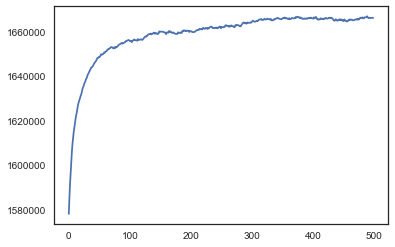

In [33]:
plt.plot(slds_lls[1:])

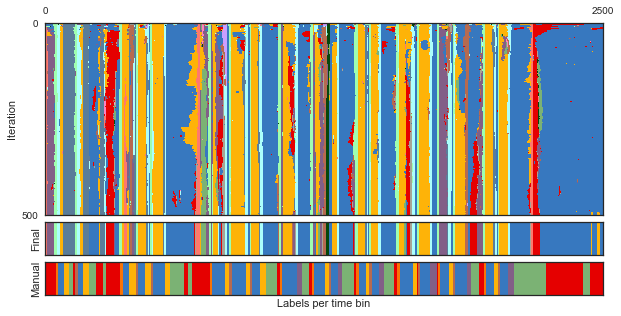

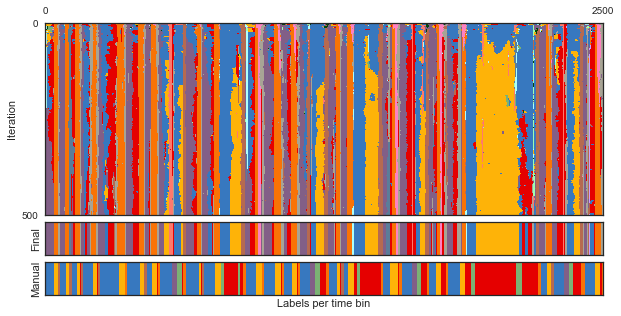

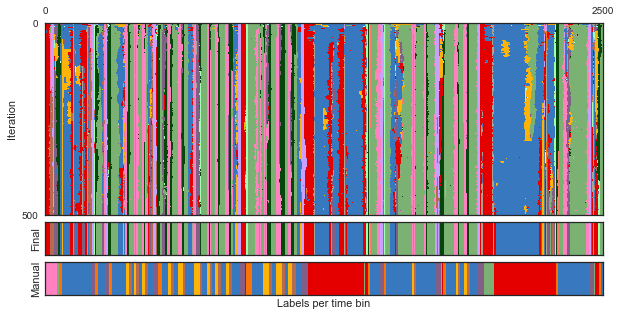

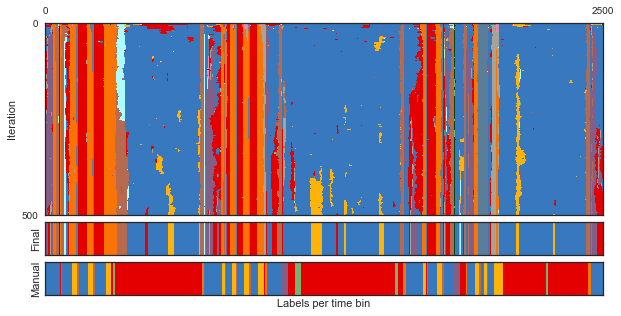

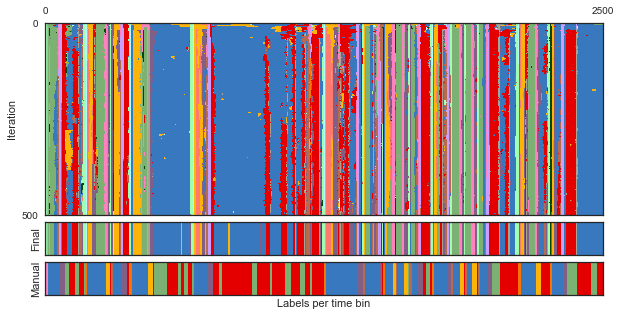

In [23]:
for worm in range(N_worms):
    plot_discrete_state_samples(
        slds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "slds_z_samples_worm{}.pdf".format(worm+1)))
    

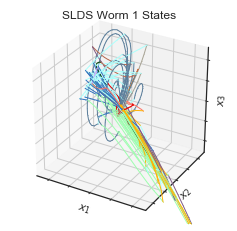

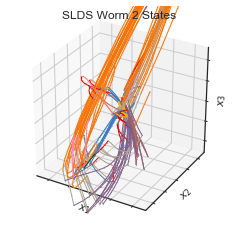

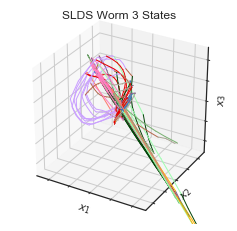

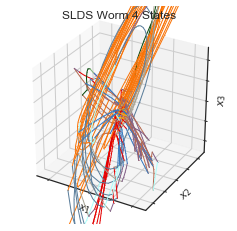

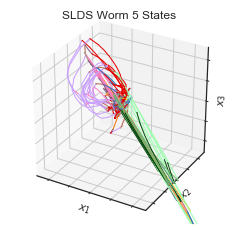

In [24]:
for worm in range(N_worms):
    plot_3d_continuous_states(slds_x_finals[worm], slds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="SLDS Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="slds_x_worm_{}.pdf".format(worm + 1),
                              lw=1,
                              lim=25)

# Fit hierarchical SLDS models

In [28]:
def make_hierarchical_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    # Scale down the strength of the prior since we have separate variances
    # for each worm. I.e. we should divide alpha and beta by N_worms.
    emission_distns = \
        HierarchicalDiagonalRegression(
            D_obs, D_latent + D_in, N_worms,
            alpha_0=alpha_0 / N_worms, beta_0=beta_0 / N_worms)

    return init_dynamics_distns, dynamics_distns, emission_distns

In [29]:
@cached("hslds")
def fit_hslds(ys, masks, init_slds=None, N_samples=500):
    print("Fitting hierarchical SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    hslds = HierarchicalWeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        hslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    if init_slds is not None:
        assert len(init_slds.states_list) == len(ys)

        for s1,s2 in zip(init_slds.states_list, hslds.states_list):
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

        hslds.init_dynamics_distns = copy.deepcopy(init_slds.init_dynamics_distns)
        hslds.dynamics_distns = copy.deepcopy(init_slds.dynamics_distns)
        hslds._emission_distn.A = copy.deepcopy(init_slds.emission_distns[0].A)
        hslds._emission_distn.sigmasq_flat = np.tile(init_slds.emission_distns[0].sigmasq_flat[None,:], (N_worms,1))
        assert hslds._emission_distn.sigmasq_flat.shape == (N_worms, D_obs)
        for k in range(Kmax):
            hslds.emission_distns[k] = hslds._emission_distn
        slds._single_emission = True
    
    else:
        # Resample parameters once to be consistent with x_init
        hslds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def gibbs_update(model):
        model.resample_model()
        return evaluate(model)
    
    # Initialize with Gibbs
    smpls = [evaluate(hslds)] + [gibbs_update(hslds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)
        
    # Compute the smoothed continuous state trajectories
    for states in hslds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]

    return hslds, lls, z_smpls, hslds.dynamics_distns, hslds.stateseqs, x_finals, sigma_x_finals

hslds0, hslds_lls0, hslds_z_smpls0, hslds_dynamics_distns0, \
    hslds_z_finals0, hslds_x_finals0, hslds_sigma_x_finals0 = \
        fit_hslds(ys=[y[:,:D_obs] for y in datasets], 
                  masks=[m[:,:D_obs] for m in data_masks], 
                  N_samples=500, init_slds=slds)

Fitting hierarchical SLDS
.........................  [  25/500,    0.42sec avg, ETA 03:18 ]
.........................  [  50/500,    0.40sec avg, ETA 03:02 ]
.........................  [  75/500,    0.41sec avg, ETA 02:54 ]
.........................  [ 100/500,    0.41sec avg, ETA 02:46 ]
.........................  [ 125/500,    0.42sec avg, ETA 02:36 ]
.........................  [ 150/500,    0.43sec avg, ETA 02:31 ]
.........................  [ 175/500,    0.44sec avg, ETA 02:23 ]
.........................  [ 200/500,    0.44sec avg, ETA 02:11 ]
.........................  [ 225/500,    0.44sec avg, ETA 02:00 ]
.........................  [ 250/500,    0.44sec avg, ETA 01:49 ]
.........................  [ 275/500,    0.44sec avg, ETA 01:38 ]
.........................  [ 300/500,    0.43sec avg, ETA 01:27 ]
.........................  [ 325/500,    0.43sec avg, ETA 01:16 ]
.........................  [ 350/500,    0.43sec avg, ETA 01:05 ]
.........................  [ 375/500,    0.43sec a

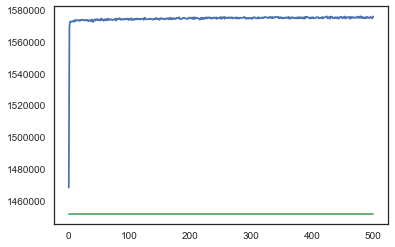

In [32]:
plt.plot(hslds_lls0)
plt.plot(slds_lls[-1] * np.ones(500))

### Refine estimate with VBEM


In [34]:
@cached("hslds_vbem")
def fit_hslds_with_vbem(hslds, N_vbem_steps=100):
    print("Fitting hierarchical SLDS with VBEM")
        
    for s in hslds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    # Refine with VBEM
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood([m[:,:D_obs] for m in data_masks])
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs
    
    def vbem_update(model):
        model.VBEM_step()
        return evaluate(model)

    smpls = [evaluate(hslds)] + [vbem_update(hslds) for itr in progprint_xrange(N_vbem_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = hslds.stateseqs
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]
    
    # Clear the expected stats before saving
    for s in hslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None

    return hslds, lls, z_smpls, hslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds = copy.deepcopy(hslds0)

hslds, hslds_lls, hslds_z_smpls, hslds_dynamics_distns, \
    hslds_z_finals, hslds_x_finals, hslds_sigma_x_finals = \
        fit_hslds_with_vbem(hslds, N_vbem_steps=100)

Fitting hierarchical SLDS with VBEM
.........................  [  25/100,    0.75sec avg, ETA 56.25 ]
.........................  [  50/100,    0.74sec avg, ETA 36.78 ]
.........................  [  75/100,    0.72sec avg, ETA 18.07 ]
.........................  [ 100/100,    0.71sec avg, ETA 0.00 ]

   0.71sec avg, 01:11 total



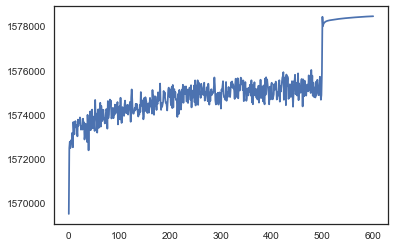

In [35]:
plt.plot(np.concatenate([hslds_lls0[1:], hslds_lls], axis=0))
# plt.plot(np.concatenate([hslds_lls], axis=0))

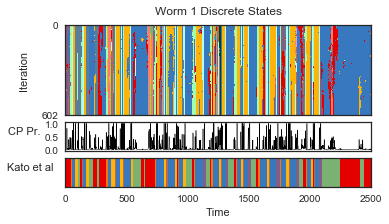

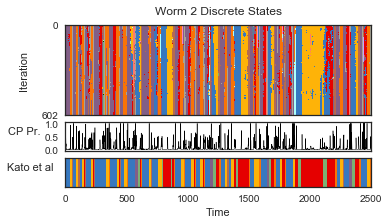

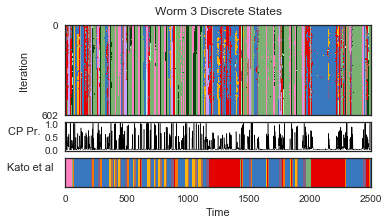

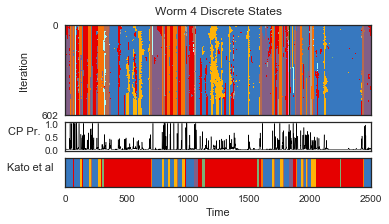

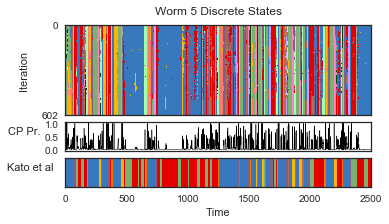

In [36]:
for worm in range(N_worms):
    plot_changepoint_prs(np.vstack((hslds_z_smpls0[worm], hslds_z_smpls[worm])), 
                         z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         plt_slice=(0,2500),
                         filepath=os.path.join(results_dir, "hslds_cps_worm{}.pdf".format(worm+1)))
    

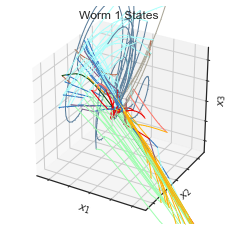

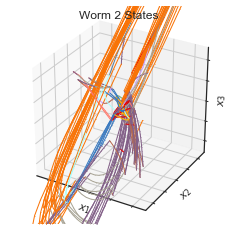

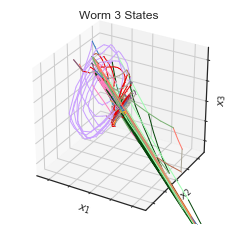

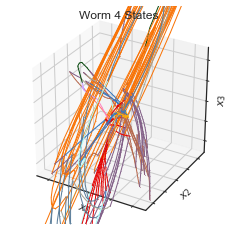

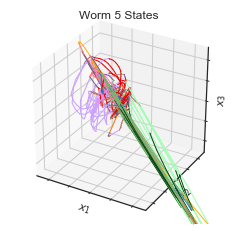

In [37]:
for worm in range(N_worms):
    plot_3d_continuous_states(hslds_x_finals[worm], hslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=25,
                              results_dir=results_dir,
                              filename="hslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

# Now fit a hierarchical _recurrent_ hSLDS

In [38]:
@cached("rhslds")
def fit_hrslds(ys, masks, N_steps=100, init_hslds=None):
    print("Fitting hierarchical recurrent SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    rslds = HierarchicalRecurrentSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        rslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    # If we've been given an hSLDS to initialize from, use its states and parameters
    if init_hslds is not None:            
        # Copy over the parameters
        rslds.init_dynamics_distns = copy.deepcopy(init_hslds.init_dynamics_distns)
        rslds.dynamics_distns = copy.deepcopy(init_hslds.dynamics_distns)
        rslds.emission_distns = copy.deepcopy(init_hslds.emission_distns)

        # Copy over the latent states
        assert len(init_hslds.states_list) == len(ys)
        for s1, s2 in zip(init_hslds.states_list, rslds.states_list):
            # Copy the sampled states
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

            # Copy the expected states and statistics
            s2.expected_states = s1.expected_states.copy()
            s2.smoothed_mus = s1.smoothed_mus.copy()
            s2.smoothed_sigmas = s1.smoothed_sigmas.copy()
            
            if s1.E_emission_stats is None:
                s1.vb_E_step_gaussian_states()
                
            s2.E_init_stats = copy.deepcopy(s1.E_init_stats)
            s2.E_dynamics_stats = copy.deepcopy(s1.E_dynamics_stats)
            s2.E_emission_stats = copy.deepcopy(s1.E_emission_stats)
        
            s2.expected_joints = s2.expected_states[:-1, :, None] * s2.expected_states[1:, None, :]
            s2._set_expected_trans_stats()

        
        # Initialize the transition model with the latent states
        rslds.initialize_transitions_from_gibbs()
        
        # Initialize the transition model to ignore continuous location
        # rslds.trans_distn.W *= 0
        # rslds.trans_distn.logpi = np.log(init_hslds.trans_distn.trans_matrix)

        # Initialize the auxiliary latent variables to be consistent
        # with the discrete and continuous latent states as well as 
        # the transition model
        for s in rslds.states_list:
            # s._init_vbem_from_gibbs()
            s.vbem_update_auxiliary_vars(n_iter=100)
            s._variational_entropy = 0

    else:
        for s in rslds.states_list:
            s._init_vbem_from_gibbs()
            s._variational_entropy = 0

    # Fit the model with VBEM
    def evaluate(model):
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model, itr):
        model.VBEM_step()
        return evaluate(model)


    smpls = [evaluate(rslds)] + [update(rslds, itr) for itr in progprint_xrange(N_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = rslds.stateseqs
    x_finals = [s.smoothed_mus for s in rslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in rslds.states_list]

    # Clear the expected stats before saving
    for s in rslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None
    
    return rslds, lls, z_smpls, rslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

# Make and fit the hierarchical rSLDS
hrslds, hrslds_lls, hrslds_z_smpls, hrslds_dynamics_distns, \
hrslds_z_finals, hrslds_x_finals, hrslds_sigma_x_finals = \
    fit_hrslds(ys=[y[:,:D_obs] for y in datasets], 
               masks=[m[:,:D_obs] for m in data_masks], 
               N_steps=100, init_hslds=hslds)

Fitting hierarchical recurrent SLDS
.........................  [  25/100,    1.63sec avg, ETA 02:02 ]
.........................  [  50/100,    1.57sec avg, ETA 01:18 ]
.........................  [  75/100,    1.56sec avg, ETA 38.93 ]
.........................  [ 100/100,    1.58sec avg, ETA 0.00 ]

   1.58sec avg, 02:38 total



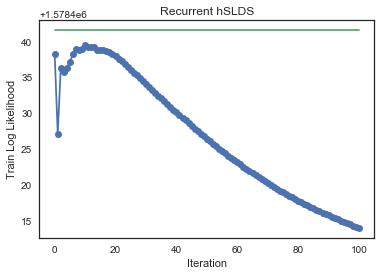

In [40]:
plt.plot(hrslds_lls, '-o')
# tmp = hslds.heldout_log_likelihood(data_masks_train)
# plt.plot(tmp * np.ones(len(hrslds_lls)))
tmp = hslds.heldout_log_likelihood([m[:,:D_obs] for m in data_masks])
plt.plot(tmp * np.ones(len(hrslds_lls)))
plt.xlabel("Iteration")
plt.ylabel("Train Log Likelihood")
plt.title("Recurrent hSLDS")

# Plot recurrent hSLDS results

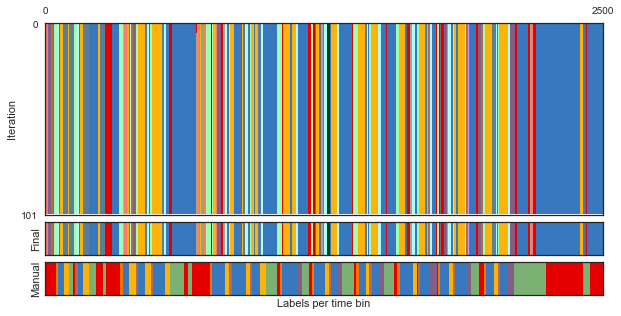

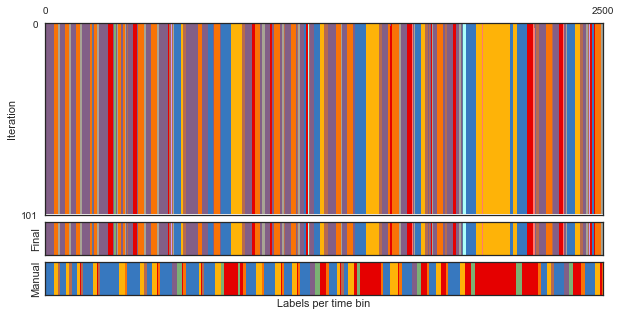

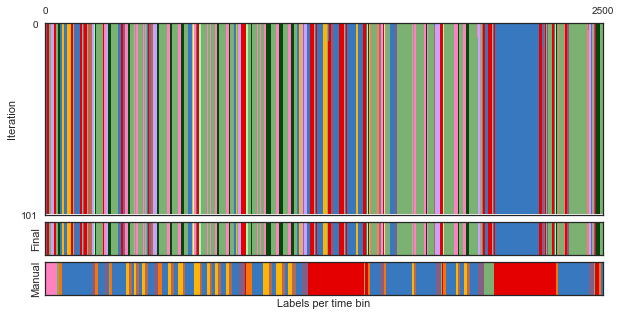

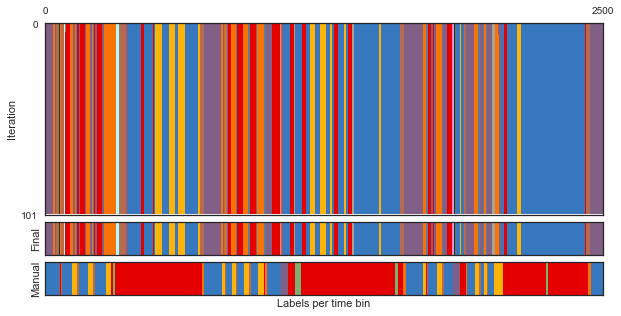

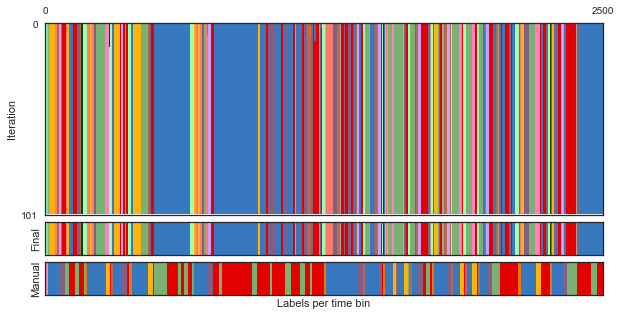

In [41]:
# Note: name the files (r)ecuzrrent (h)ierarhical instead of hr... 
#       this will make it easier to navigate the results directory
for worm in range(N_worms):
    plot_discrete_state_samples(
        hrslds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "rhslds_z_samples_worm{}.pdf".format(worm+1)))

# Heldout neuron classification

cluster sizes:  [17 22  1 14  5  1]


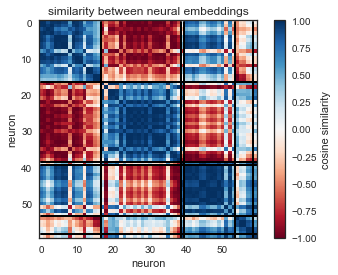

In [305]:
C_true = hrslds.emission_distns[0].A[:,:-1]
S_true = C_true.dot(C_true.T)
S_true /= np.linalg.norm(C_true, axis=1)[:, None]
S_true /= np.linalg.norm(C_true, axis=1)[None, :]

from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
N_clusters = 6
cluster = SpectralClustering(n_clusters=N_clusters, affinity="precomputed")
cluster.fit((1+S_true) / 2.0)
# cluster = SpectralClustering(n_clusters=N_clusters)
# cluster.fit(C_true)

labels = cluster.labels_

avg_C = np.zeros((N_clusters, D_latent))
for c in range(N_clusters):
    if not np.any(labels==c):
        continue
    avg_C[c] = np.mean(C_true[labels==c], axis=0)


# labels_perm = np.argsort(avg_C[:,2])
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
weights = pca.fit_transform(avg_C)[:,0]
labels_perm = np.argsort(weights)
avg_C = avg_C[labels_perm]
labels = relabel_by_permutation(labels, np.argsort(labels_perm))

perm = np.lexsort(np.row_stack((C_true.T, labels)))
iperm = np.argsort(perm)
# print(labels)
# print(labels[perm])

plt.imshow(S_true[np.ix_(perm, perm)], cmap="RdBu", vmin=-1, vmax=1)

cluster_sizes = np.bincount(labels, minlength=N_clusters)
print("cluster sizes: ", cluster_sizes)
offsets = np.cumsum(cluster_sizes) - 1
for o in offsets[:-1]:
    plt.plot([o+.5, o+.5], [0, D_obs], '-', lw=2, color=0 * np.ones(3))
    plt.plot([0, D_obs], [o+.5, o+.5], '-', lw=2, color=0 * np.ones(3))
plt.xlim(-0.5, D_obs-0.5)
plt.ylim(D_obs-0.5, -0.5)
plt.xlabel("neuron")
plt.ylabel("neuron")
plt.title("similarity between neural embeddings")
plt.colorbar(label="cosine similarity")

In [306]:
offset = 0
for c in range(N_clusters):
    print("Cluster ", c)
    cluster_names = []
    for n in range(offset, D_obs):
        if labels[perm[n]] > c:
            offset = n
            break
        cluster_names.append(all_neuron_names[perm[n]])

    print([name for name in sorted(cluster_names)])
    print("")

Cluster  0
['AIBL', 'AIBR', 'ASKL', 'ASKR', 'AVAL', 'AVAR', 'BAGL', 'RIML', 'RIMR', 'RIVL', 'RIVR', 'SAAVL', 'SAAVR', 'SABVL', 'SMDVL', 'SMDVR', 'VA01']

Cluster  1
['ALA', 'AVBL', 'AVBR', 'AVFR', 'DB01', 'DB02', 'RIBL', 'RIBR', 'RID', 'RIFR', 'RIGL', 'RIGR', 'RIS', 'RMED', 'RMEL', 'RMER', 'RMEV', 'SIADL', 'SIBDR', 'SIBVL', 'SIBVR', 'VB01']

Cluster  2
['SMBVR']

Cluster  3
['AS01', 'AVEL', 'AVER', 'AVFL', 'DA01', 'OLQDL', 'OLQDR', 'OLQVL', 'OLQVR', 'SABD', 'SABVR', 'SMBDR', 'URYDL', 'URYDR']

Cluster  4
['SMBDL', 'URADL', 'URADR', 'URYVL', 'URYVR']

Cluster  5
['SMBVL']



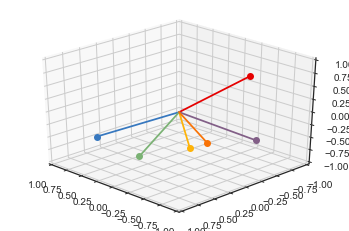

In [326]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
avg_C_norm = avg_C / np.linalg.norm(avg_C, axis=1)[:, None]
for c in range(N_clusters):
    plt.plot([0, avg_C_norm[c, 0]],
             [0, avg_C_norm[c, 1]],
             [0, avg_C_norm[c, 2]],
             '-', color=colors[c])
    plt.plot([avg_C_norm[c, 0]],
             [avg_C_norm[c, 1]],
             [avg_C_norm[c, 2]],
             'o', color=colors[c])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.view_init(azim=135)

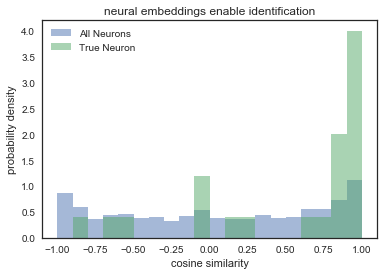

In [309]:
# Fit a linear regression to get the mapping from X to Y for all heldout neurons
from sklearn.linear_model import LinearRegression
model = hslds
states = hslds_x_finals
C_true = model.emission_distns[0].A[:,:-1]

similarities = []
true_similarities = []
for worm in range(N_worms):
    Cs_worm = np.zeros((N_heldout, D_latent))
    for i,n in enumerate(heldout_neurons[worm]):
        X = states[worm]
        y = datasets[worm][:,n]
        m = data_masks[worm][:,n]
        assert not np.any(m)
        reg = LinearRegression().fit(X, y)
        Cs_worm[i] = reg.coef_
                
        # Compute cosine similarity between the inferred C and the hrslds emission matrix
        sim = np.dot(C_true, Cs_worm[i]) / np.linalg.norm(C_true, axis=1) / np.linalg.norm(Cs_worm[i])

        similarities.append(sim)
        true_similarities.append(sim[n])

similarities = np.concatenate(similarities)
true_similarities = np.array(true_similarities)
# lim = np.abs(similarities).max()
lim = 1
bins = 20
plt.hist(similarities, np.linspace(-lim,lim,bins+1), alpha=0.5, normed=True, label="All Neurons")
plt.hist(true_similarities, np.linspace(-lim,lim,bins+1), alpha=0.5, normed=True, label="True Neuron")
plt.legend(loc="upper left")
plt.title("neural embeddings enable identification")
plt.xlabel("cosine similarity")
plt.ylabel("probability density")
plt.savefig(os.path.join(results_dir, "similarity_comparison.pdf"))
plt.savefig(os.path.join(results_dir, "similarity_comparison.png"))

# See if neurons have different amplitude across worms

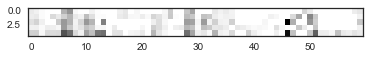

In [332]:
sigma_obs = np.zeros((N_worms, D_obs))
for worm in range(N_worms):
    sigma_obs[worm] = datasets[worm][:,:D_obs].std(0)

plt.imshow(sigma_obs)